# Marco Lavorini   -  Assignment 3

# RBM from scratch



In [170]:
# this cell is for loading the mnist dataset

import idx2numpy
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from tqdm import tqdm



def read_idx(filename):
    array = idx2numpy.convert_from_file(filename)
    return array

files = ["train-images.idx3-ubyte", "train-labels.idx1-ubyte", "t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte"]

print(os.path.join("..", "datasets", "mnist", files[0]))
x_train = read_idx(os.path.join("..", "datasets", "mnist", files[0]))
y_train = read_idx(os.path.join("..", "datasets", "mnist", files[1]))
x_test = read_idx(os.path.join("..", "datasets", "mnist", files[2]))
y_test = read_idx(os.path.join("..", "datasets", "mnist", files[3]))

print(y_train)





../datasets/mnist/train-images.idx3-ubyte
[5 0 4 ... 5 6 8]


After loading the dataset we preprocess it by rescaling the dataset in a [0,1] range and flattening each image, originally rapresented by a 28x28 matrix, in a one dimensional array.

In [418]:
# this cell is for preprocessing the data

x_train_b = np.where(x_train > 0, 1, 0)
x_test_b = np.where(x_test > 0, 1, 0)

x_train_b = x_train/255
x_test_b = x_test/255

x_train_flatten = x_train_b.reshape(x_train_b.shape[0], -1)
x_train_flatten.shape

x_test_flatten = x_test_b.reshape(x_test_b.shape[0], -1)
x_test_flatten.shape





(10000, 784)

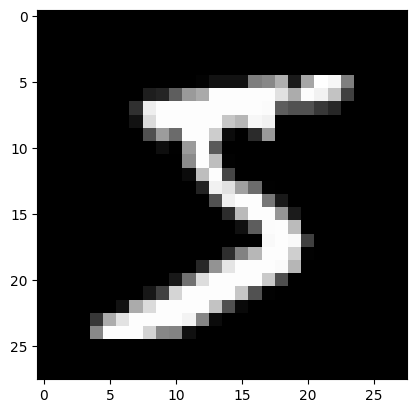

In [172]:
#print first element in data using matplot lib
plt.imshow(x_train_b[0], cmap='gray')
plt.show()

# Point 1

## Main code for RBM class with training algorithm (Contrastive Divergence Learning) and some utils

### Sigmoid function

In [173]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

### MSE

In [174]:
def mse(net):   
    metric = []
    for i in range(len(x_test_b[0:3000])):
        img = i
        original = x_test_flatten[img]
        recon = net.reconstruct(original).T
        metric.append(mean_squared_error(original, recon))
    return np.mean(metric)


In [238]:

class rbm:
    def __init__(self, num_visible, num_hidden):
        self.h = num_hidden
        self.v = num_visible
        self.W = np.random.uniform(-0.05, 0.05, (num_visible, num_hidden))
        self.bh = np.zeros(num_hidden)
        self.bv = np.zeros(num_visible)    
    
    def fit_batch(self, data, epochs=10, lr=0.01, batch_size=10):
        metric = []
        iter = len(data)/batch_size
        for epoch in tqdm(range(epochs)):
            for i in range(int(iter)):
                X = data[i*batch_size:i*batch_size+ batch_size]
                # wake part
                pos_def_P = sigmoid(np.dot(X, self.W) + self.bh)
                wake = np.dot(X.T, pos_def_P)

                # dream part
                pos_hid_S = pos_def_P > np.random.rand(len(pos_def_P), len(pos_def_P[0])) # stochastic hidden activation
                recon_data_P = sigmoid(np.dot(pos_hid_S, self.W.T) + self.bv) #reconstructed data

                recon_data = recon_data_P > np.random.rand(len(recon_data_P), len(recon_data_P[0]))
                neg_hid_P = sigmoid(np.dot(recon_data, self.W) + self.bh)
                dream = np.dot(recon_data.T, neg_hid_P)
                
                # update weights
                deltaW = (wake - dream)/len(X)
                deltaBh = (np.sum(pos_def_P) - np.sum(neg_hid_P))/len(X)
                deltaBv = (np.sum(X) - np.sum(recon_data))/len(X)
                self.W += lr * deltaW
                self.bh += lr * deltaBh
                self.bv += lr * deltaBv

            metric.append(mse(self))
        return metric

    # reconstruct the data using the trained weights
    def reconstruct(self, X):
        hidden = sigmoid(np.dot(X.T, self.W) + self.bh)
        reconstructed = sigmoid(np.dot(hidden, self.W.T) + self.bv)
        return reconstructed
    
    # get the hidden layer
    def hidden(self, X):
        return sigmoid(np.dot(X.T, self.W) + self.bh)
    

# Training and experiment phase

In [422]:
net_batch = rbm(x_train_flatten.shape[1], 512)
print(f'v = {net_batch.v}')
print(f'h = {net_batch.h}')

v = 784
h = 512


In [423]:
x_train_b.shape
x_train_flattened_batch = x_train_b.reshape(x_train_b.shape[0], -1)

In [424]:
losses = net_batch.fit_batch(x_train_flattened_batch[:4000], epochs=100, lr=0.01, batch_size=10)

100%|██████████| 100/100 [13:52<00:00,  8.33s/it]


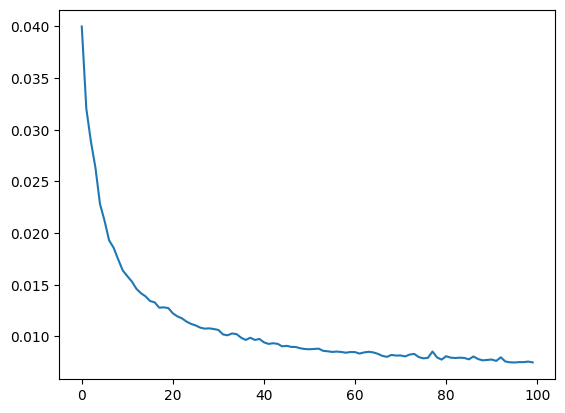

In [425]:
# plot the losses
plt.plot(losses)
plt.show()

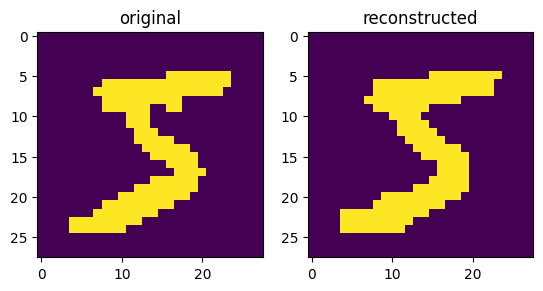

In [427]:
img = 0
original = x_train_flatten[img]
recon = net_batch.reconstruct(original)
# threshold the image, 0 if equals to 0 1 otherwhise
original_t = np.where(original > 0.09, 1, 0)
recon_t = np.where(recon > 0.09, 1, 0)
# print the image with matplotlib
plt.subplot(1, 2, 1)
plt.imshow(original_t.reshape(28, 28))
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(recon_t.reshape(28, 28))
plt.title('reconstructed')

plt.show()


In [428]:
# calculate jaccard similarity
from sklearn.metrics import jaccard_score
jaccard_score(original_t, recon_t.T)


0.8703703703703703

# Point 2

## Encoding of one of each digit using the trained RBM

[1, 3, 5, 7, 2, 0, 13, 15, 17, 4]


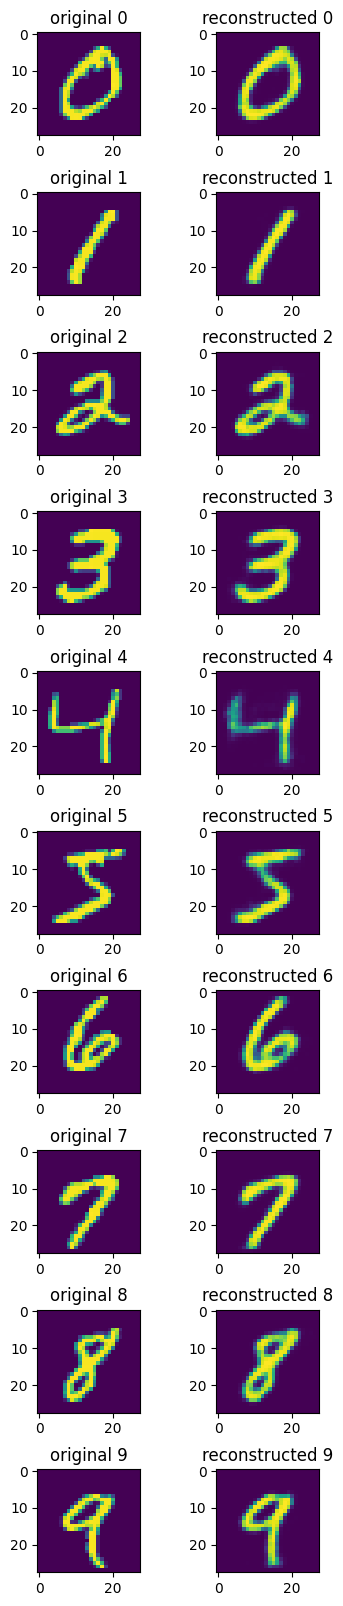

In [430]:
# find the first of each number in the dataset
digits = []
for i in range(10):
    digits.append(np.where(y_train == i)[0][0])
print(digits)

plt.figure(figsize=(10, 20))
for i in range(10):
    plt.subplot(10, 2, 2*i+1)
    plt.imshow(x_train[digits[i]])
    plt.title(f'original {y_train[digits[i]]}')
    plt.subplot(10, 2, 2*i+2)
    plt.imshow(net_batch.reconstruct(x_train_flatten[digits[i]]).reshape(28, 28))
    plt.title(f'reconstructed {y_train[digits[i]]}')
plt.subplots_adjust(hspace = 0.55)
plt.subplots_adjust(wspace = -0.7)

## printing the best and the worst recontruscted image according to MSE

0.007479823000829352
341 272


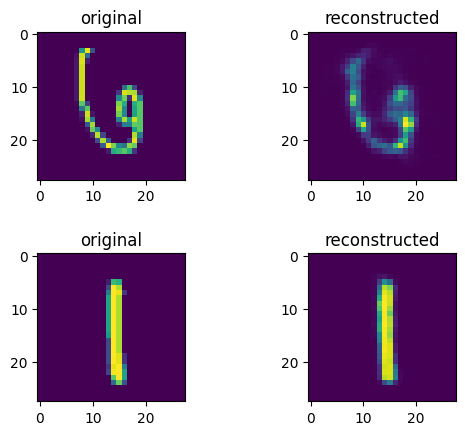

In [433]:
metric = []
for i in range(len(x_test_b[0:3000])):
    img = i
    original = x_test_flatten[img]
    recon = net_batch.reconstruct(original).T
    metric.append(mean_squared_error(original, recon))
print(np.mean(metric))

max = metric.index(np.max(metric))
min = metric.index(np.min(metric))

print(max, min)
plt.subplot(2, 2, 1)
plt.imshow(x_test_flatten[max].reshape(28, 28))
plt.title('original')
plt.subplot(2, 2, 2)
plt.imshow(net_batch.reconstruct(x_test_flatten[max]).reshape(28, 28))
plt.title('reconstructed')
plt.subplot(2, 2, 3)
plt.imshow(x_test_flatten[min].reshape(28, 28))
plt.title('original')
plt.subplot(2, 2, 4)
plt.imshow(net_batch.reconstruct(x_test_flatten[min]).reshape(28, 28))
plt.title('reconstructed')
plt.subplots_adjust(hspace = 0.5)  # Adjust the vertical spacing here

plt.show()


#### we can see, by plotting some weights as images, what the network tried to learn

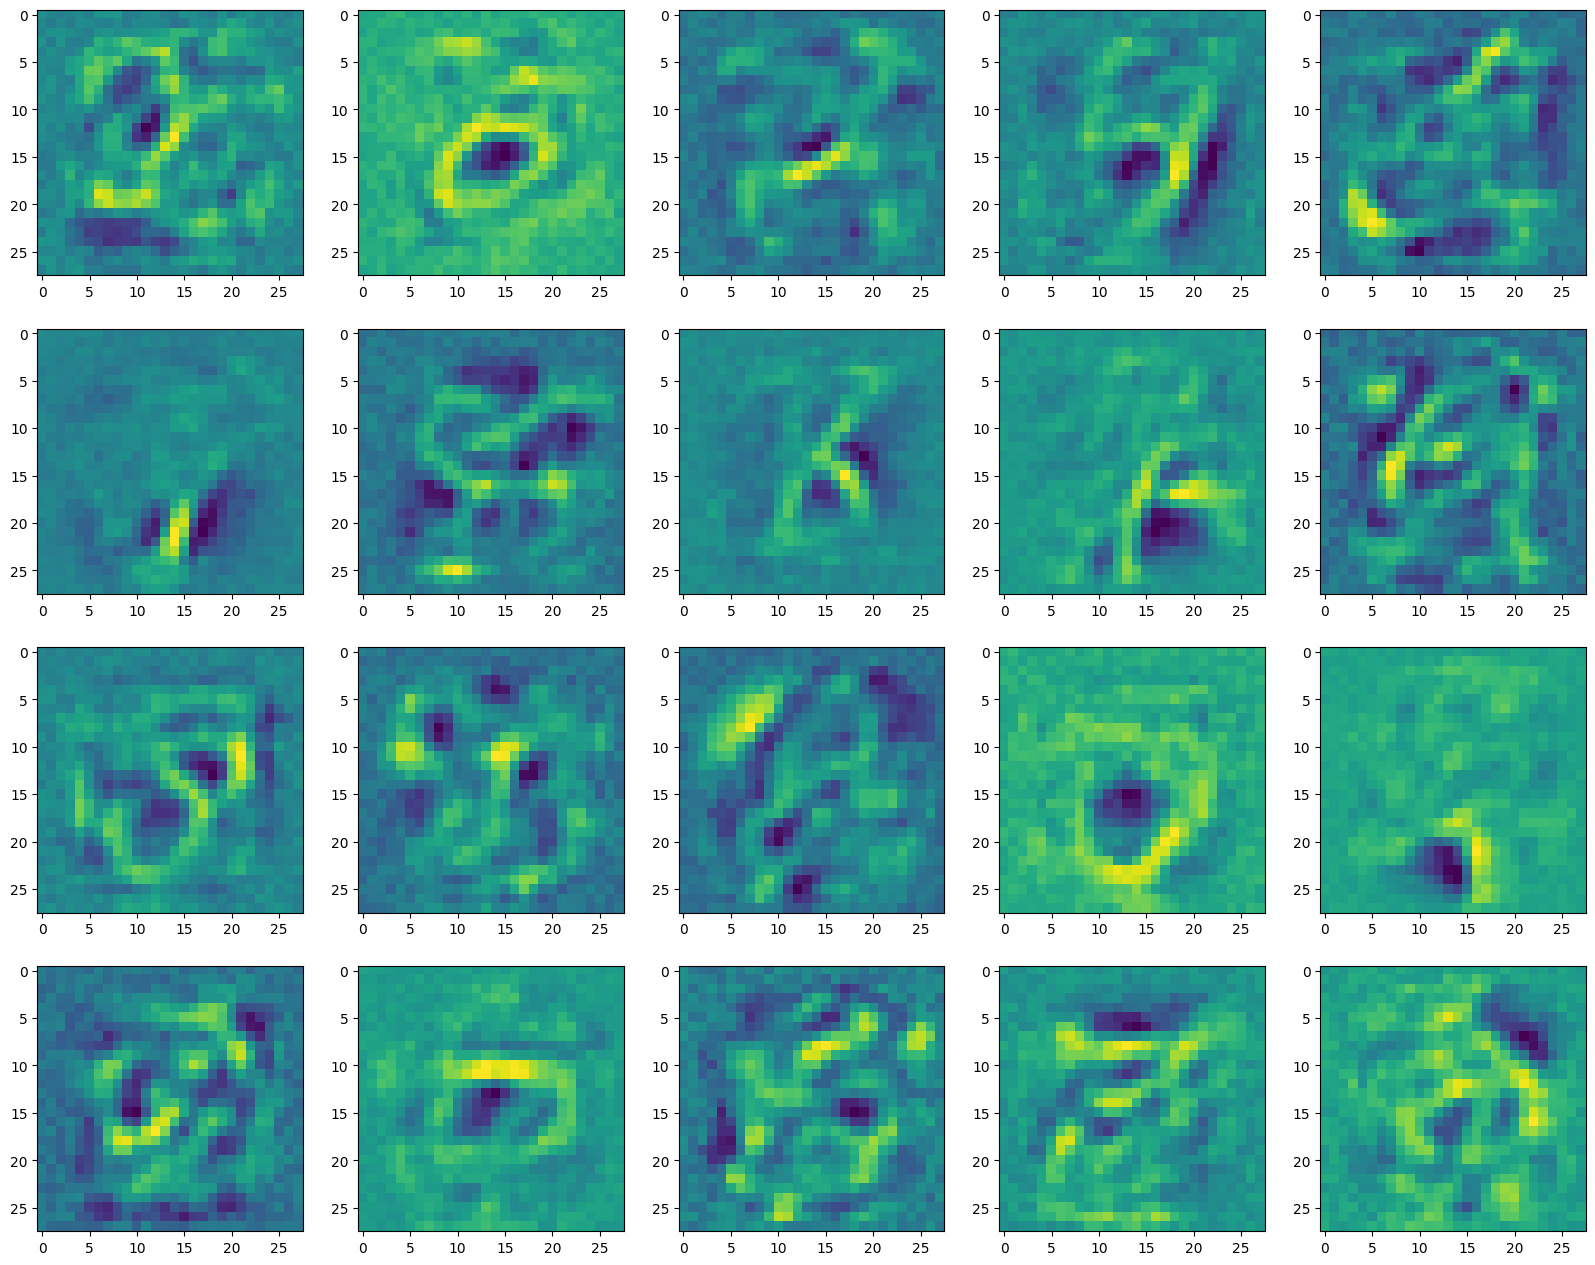

In [435]:
filters = net_batch.W.T
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 5, i+1)
    plt.imshow(filters[i].reshape(28, 28))
plt.show()


# Step 3.

## Train a simple classifier to recognize the MNIST digits using as inputs their encoding obtained at step 2.


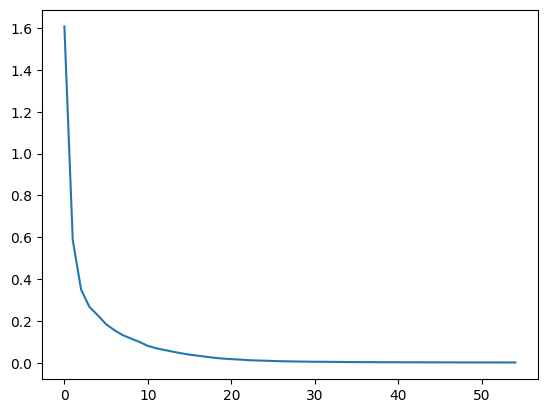

In [441]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, verbose=False)
mlp.fit(x_train_flatten[:5000], y_train[:5000]) # TODO:watch out i worked with the test set before, to fix

y_pred = mlp.predict(x_test_flatten)
accuracy_score(y_test[:3000], y_pred[:3000])

plt.plot(mlp.loss_curve_)
plt.show()

# now do a model selection with the best classifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

scorer = make_scorer(accuracy_score)


In [438]:
print(accuracy_score(y_test[:3000], y_pred[:3000]))

0.9316666666666666


In [439]:
X_enc = []
for i in tqdm(range(5000)):
    img = i
    original = x_train_flatten[img]
    enc = net_batch.hidden(original)
    X_enc.append(enc)

# do the same 

X_enc_test = []
for i in tqdm(range(3000)):
    img = i
    original = x_test_flatten[img]
    enc = net_batch.hidden(original)
    X_enc_test.append(enc)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 3000/3000 [00:01<00:00, 1871.19it/s]


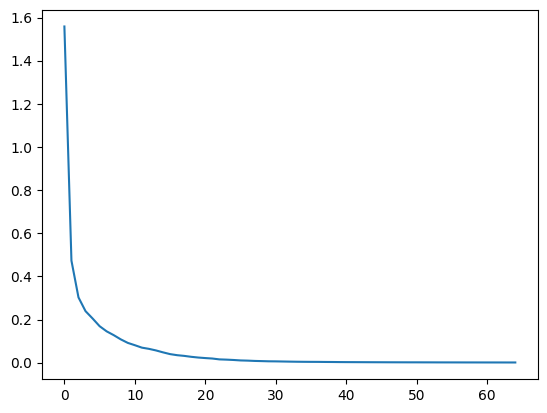

0.9376666666666666


In [440]:
# train a mlp with the encoded data and plot the accuracy and loss, during training show the time remaining
mlp_enc = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, verbose=False)
mlp_enc.fit(X_enc, y_train[:5000])

y_pred_enc = mlp_enc.predict(X_enc_test)
accuracy_score(y_test[:3000], y_pred_enc)

plt.plot(mlp_enc.loss_curve_)
plt.show()

print(accuracy_score(y_test[:3000], y_pred_enc))

I trained two models, the first one on the original dataset and the second one on the encoded data using the trained RBM.
The result are similar, in particular, the classifier trained on the original MNIST resulted in a 0.932 accuracy while the one on the encoding was lighlty better with a 0.938 accuracy score. Note that a the same simple model was used for both tests. 

# Extra

what happens if we train a RBM with a subset of the MNIST dataset with only the same digit?

In [442]:
# get the first 100 images of 4 in the training set
idx = np.where(y_train == 4)[0][:200]
X_4 = []
for i in tqdm(range(200)):
    X_4.append(x_train_flatten[idx[i]])

X_4 = np.array(X_4)
print(X_4.shape)


100%|██████████| 200/200 [00:00<00:00, 704333.17it/s]

(200, 784)


In [443]:
rbm_4 = rbm(784, 512)
metric = rbm_4.fit_batch(X_4, epochs=50, lr=0.01, batch_size=10)

100%|██████████| 50/50 [02:33<00:00,  3.07s/it]


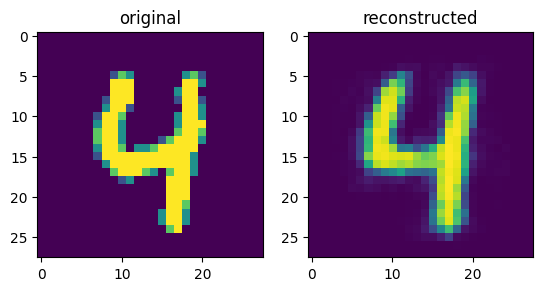

In [444]:
# print the first image of 4 and its reconstruction
img = 20
original = X_4[img]
recon = rbm_4.reconstruct(original)
plt.subplot(1, 2, 1)
plt.imshow(original.reshape(28, 28))
plt.title('original')
plt.subplot(1, 2, 2)
plt.imshow(recon.reshape(28, 28))
plt.title('reconstructed')
plt.show()


In [445]:
noise = np.random.rand(784)

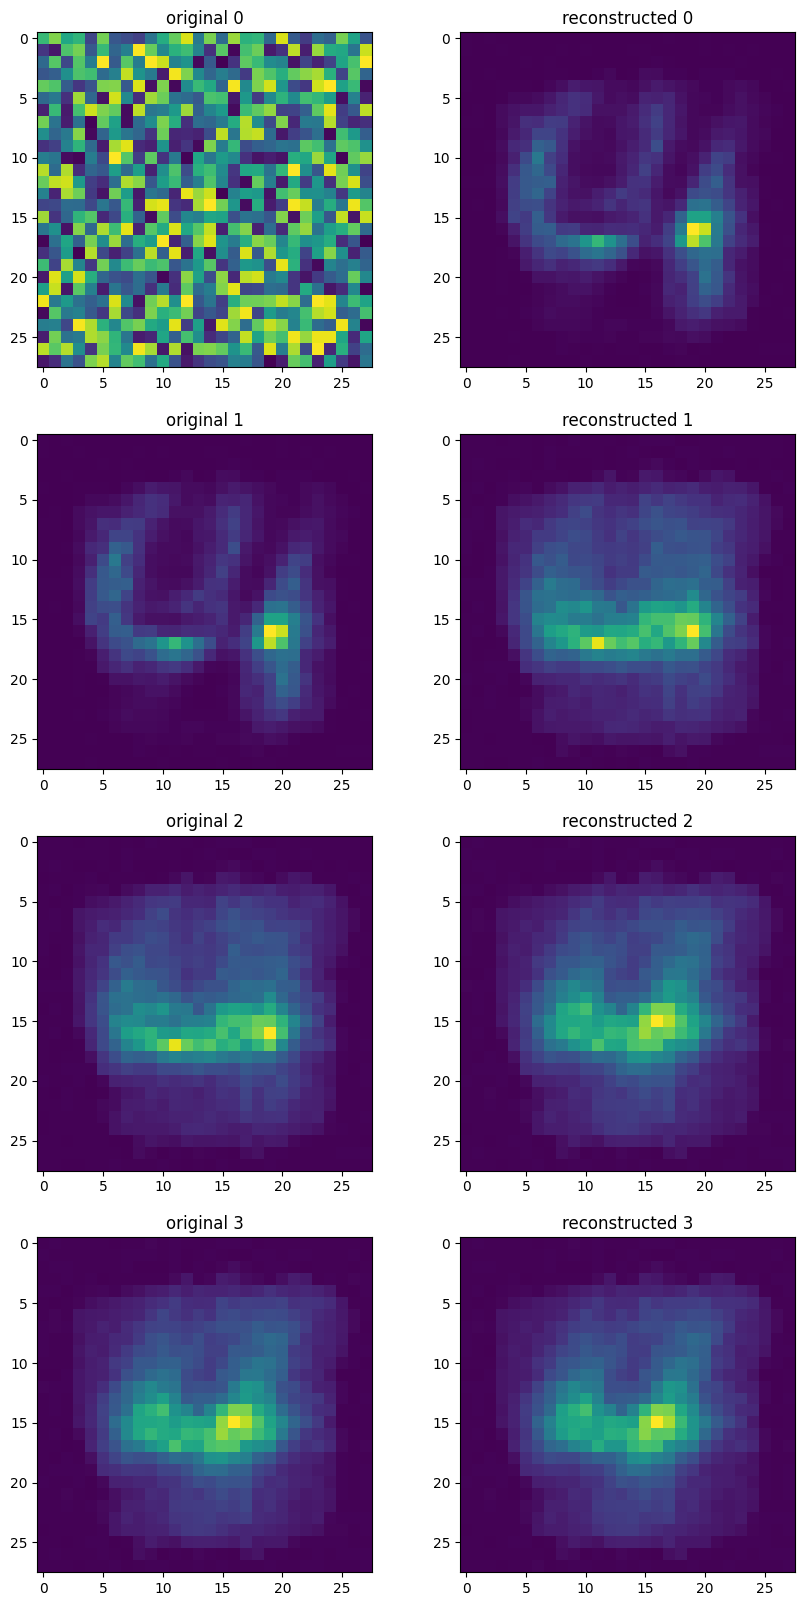

In [446]:
# reconstruct the noise 5 times and plot the images in a 5x2 grid by using the last reconstructed image as input for the next one
plt.figure(figsize=(10, 20))
for i in range(4):
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(noise.reshape(28, 28))
    plt.title(f'original {i}')
    plt.subplot(4, 2, 2*i+2)
    noise = rbm_4.reconstruct(noise)
    plt.imshow(noise.reshape(28, 28))
    plt.title(f'reconstructed {i}')

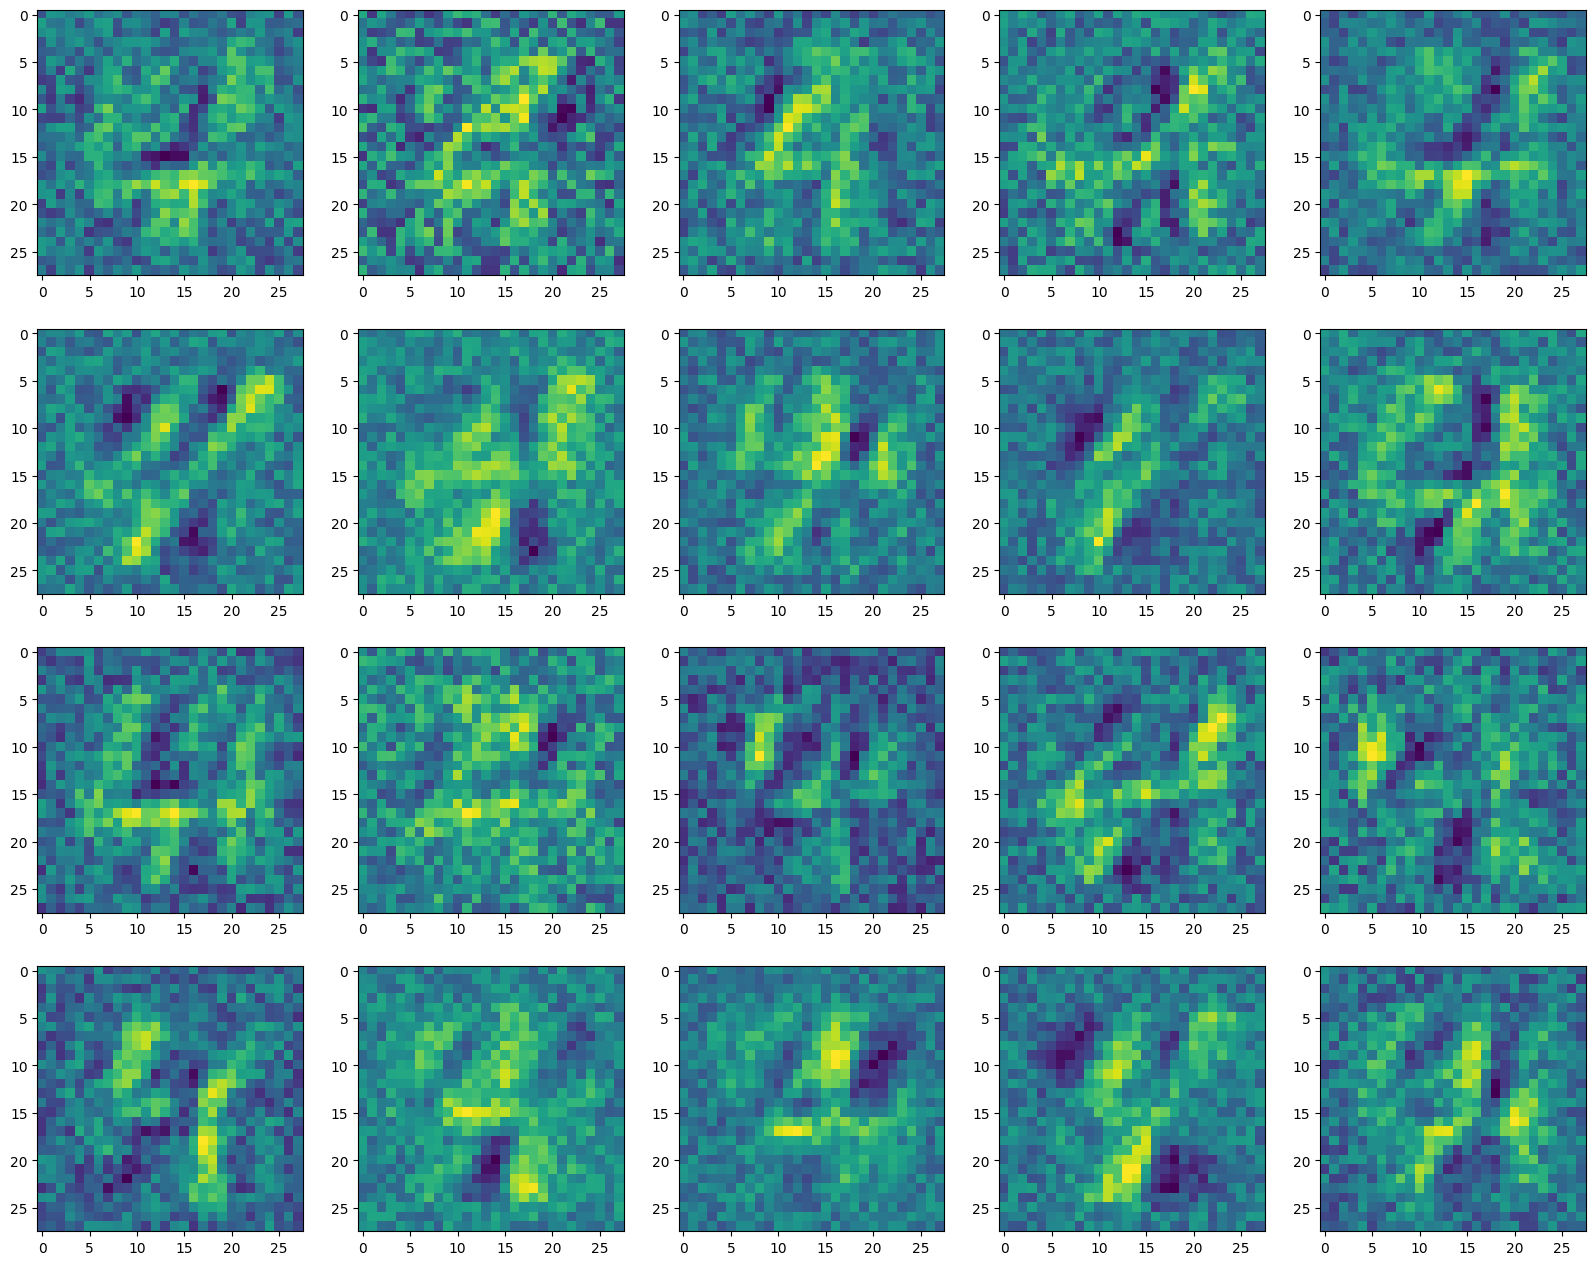

In [447]:
# print the filter
filters = rbm_4.W.T
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 5, i+1)
    plt.imshow(filters[i].reshape(28, 28))
plt.show()